In [57]:
from bertopic import BERTopic
from bs4 import BeautifulSoup
from collections import Counter, deque
import csv
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import os
import pandas as pd
import random
import re 
import requests
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
import time
import token 
from urllib.parse import urljoin
from urllib.parse import urlparse


In [51]:
nltk.download('punkt')
nltk.download('punkt_tab') # Nécessaire pour les nouvelles versions
nltk.download('wordnet')
nltk.download('omw-1.4')   # Souvent requis par le lemmatizer
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
# --- CONFIGURATION OF COLORS ---

GREEN = "\033[92m"
RED = "\033[91m"
YELLOW = "\033[93m"
BLUE = "\033[94m"
RESET = "\033[0m"

In [25]:
HEADER = {
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/143.0.0.0 Safari/537.36 Edg/143.0.0.0",
    "Accept-Language": "en-US,en;q=0.5",
    "Referer": "https://www.google.com/"}

session = requests.Session()
session.headers.update(HEADER)

In [26]:
Filters_MBG = [r'/products?/', r'/shop/', r'/search?', r'/store/', r'/cart', r'/checkout', r'/account', 
           r'/login', r'/register', r'/tag', r'/search', r'#', "youtube.com", 
           "instagram.com", "facebook.com", "twitter.com", "pinterest.com", "linkedin.com", "tiktok.com", 
           "amazon.com", "google.com"]

In [27]:
def fetch_verify_url(url) :
    try:
        response = session.get(url, timeout=10)
        if response.status_code != 200:  # If the status code is not OK (200) the function return none and an error message
            print(f"Failed to fetch the url: {url} with status code {response.status_code}")
            return None
        return response  
    except requests.RequestException:
        return None

In [28]:
def to_soup(url):
    response = fetch_verify_url(url)
    if response:  # If the response is not none, the function return the beautiful soup object
        return BeautifulSoup(response.text, 'html.parser') 
    else:
        return None

In [29]:
def extract_MBG_links(url_MBG, max_levels=3):
    queue = deque([(url_MBG, 0)])
    links_MBG = set([url_MBG])
    start_domain = urlparse(url_MBG).netloc

    while queue:
        current_url, current_level = queue.popleft()

        # Si on atteint le niveau max, on arrête de creuser à partir d'ici
        if current_level >= max_levels:
            continue
    
        soup = to_soup(current_url)
        if not soup:
            continue

        content_area = soup.find('div', id='content') or soup.body
        if not content_area:
            continue

        for item in content_area.find_all('a', href=True):
            href = item.get('href')
            full_url = urljoin(current_url, href)
                    
            # Si nouveau lien trouvé
            if any(filter in full_url for filter in Filters_MBG):
                continue
            
            if full_url not in links_MBG:
                links_MBG.add(full_url)

                # On ajoute à la queue SEULEMENT si c'est interne (pour continuer le crawl)
                if urlparse(full_url).netloc == start_domain:
                    queue.append((full_url, current_level + 1))
                    
    return links_MBG

In [30]:
def create_filepath():

    user_filename = input("Enter the name of the file to save (e.g. : test) : ").strip() #strip deletes spaces before and after the string
    
    if not user_filename : 
        user_filename = "test"
    
    if not user_filename.endswith('.csv'): # Verify if the filename ends with .csv
        user_filename += '.csv' # Append .csv if not present
    filename = os.path.join("data", user_filename) # Construct the full file path

    # Create directory if not exists
    directory = os.path.dirname(filename)
    if directory and not os.path.exists(directory):
        os.makedirs(directory)
        print(f"{GREEN}Created directory : {os.path.abspath(directory)}{RESET}") # Full path info
    print(f'{BLUE}Output will be saved to : "{filename}_raw_html"{RESET}')

    # Avertissement si écrasement (juste pour info)
    if os.path.exists(filename):
        print(f"{BLUE}Note : The file is overwritten{RESET}") 
    
    return filename


ATTENTION : Pour get_html_content() de TOUS les liens, il faut retirer : 
1. le max=10 dans les paramètres 
2. le [:max] dans la première boucle for

In [31]:
def get_html_content(links, max=10):
    content = []
    failed_links = []
    #filename = create_filepath()

    for link in links[:max]:
        response = fetch_verify_url(link)
        if response:
            content.append({'url': link, 'html': response.text})
        else:
            failed_links.append(link)

    print(f"{GREEN}Fetched: {len(content)} {BLUE}|{RED} Failed: {len(failed_links)}{RESET}")

    return content, failed_links 

In [32]:
def clean_html(html):
    soup = BeautifulSoup(html, 'html.parser')

    for tag in soup(['script', 'style', 'noscript']):  # Supress any unessecary tags
        tag.decompose()

    text = soup.get_text(separator=' ', strip=True)  # Collect all visible text
    text = re.sub(r'\s+', ' ', text)  # Supress any unecessary spaces

    return text

In [33]:
def clean_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the raw html as the input

    if 'corpus_text' not in df.columns:  # Verify that the html colon exists
        raise ValueError(f"The corpus column is missing in: {input_csv}")

    df['cleaned_text'] = df['corpus_text'].apply(clean_html)  # Cleans the html column
    df = df[['url', 'cleaned_text']]  # Keep the url and text colon (not the raw html)

    df.to_csv(output_csv, index=False, encoding='utf-8')  # Creats a new csv file as the output of the function

    return df

In [ ]:
def save_to_csv(data, filename):
    if not data:
        print(f"{RED}No data to save.{RESET}")
        return

    # Get the keys from the first dictionary for the CSV header from get_html_content
    fieldnames = data[0].keys() # Detection of the existing colons in the data file
    
    try:
        with open(filename, 'w', newline='', encoding='utf-8') as f: # Opens the csv file as utf-8
            writer = csv.DictWriter(f, fieldnames=fieldnames, quoting=csv.QUOTE_ALL) # Initialising a writer to write the dictionary into the csv file
            writer.writeheader() # writes the colons headers
            writer.writerows(data) # writes the rows
        print(f"{GREEN}Success! Data saved to: {RESET}{os.path.abspath(filename)}")
        
    except Exception as e:
        print(f"{RED}Error saving file: {e}{RESET}")

In [35]:
def get_files_name() :
    print("Files in data directory :")
    print(os.listdir("data"))

In [36]:
def get_corpus(html):
    if not html: 
        return ""

    soup = BeautifulSoup(html, "html.parser")

    for tag in soup(["script", "style", "nav", "noscript"]):
        tag.decompose()

    raw_text = soup.get_text(separator=' ', strip=True)
    
    text = ' '.join(raw_text.split())

    return text

In [37]:
def corpus_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the raw html as the input

    if 'html' not in df.columns:  # Verify that the html colon exists
        raise ValueError(f"The html column is missing in: {input_csv}")

    df['corpus_text'] = df['html'].apply(get_corpus)  # Cleans the html column
    df = df[['url', 'corpus_text']]  # Keep the url and text colon (not the raw html)

    df.to_csv(output_csv, index=False, encoding='utf-8')  # Creats a new csv file as the output of the function

    return df

In [38]:
def normalize_html(text):
    text = text.lower()  # convert all letters to lowercase
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers like [1], [2], etc.
    text = re.sub(r'\d+', ' ', text)  # remove all numbers
    text = re.sub(r'[^a-z\s]', ' ', text)  # keep only English letters and spaces
    text = re.sub(r'\s+', ' ', text)  # replace multiple spaces with a single space
    return text.strip()  # remove leading and trailing spaces

In [39]:
def normalize_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the cleaned text as the input

    if 'cleaned_text' not in df.columns:  # Verify that the cleaned text colon exists
        raise ValueError(f"The cleaned text is missing in: {input_csv}")

    df['normalized_text'] = df['cleaned_text'].apply(normalize_html)  # normalize the cleaned text
    df = df[['url', 'normalized_text']]  # keep the url and normalized text 

    df.to_csv(output_csv, index=False, encoding='utf-8')  # creats a new csv file as the output of the function

    return df

#cleaned_MBG_csv = "data/mbg_cleaned_pages.csv"

In [40]:
nltk.download('stopwords') 
stop_words = list(set(stopwords.words('english'))) + ["'s"]

stop_words = set(stopwords.words('english'))

#stem = nltk.stem.SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

def tokenize_html(text):
    if not isinstance(text, str) or pd.isna(text):
        return [] # Return empty list for non-string or NaN inputs (= when text is missing)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]  # remove punctuation
    tokens = [token for token in tokens if token not in stop_words]  # remove stopwords
    #tokens = [stem.stem(token) for token in tokens]  # apply stemming (racinisation)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # apply lemmatization
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
def tokenize_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the normalized text as the input

    if 'normalized_text' not in df.columns:  # Verify that the normalized text colon exists
        raise ValueError(f"The normalized text is missing in: {input_csv}")

    # SÉCURITÉ : On remplit les trous par du vide pour éviter les NaN
    df['normalized_text'] = df['normalized_text'].fillna("") 

    df['tokenized_text'] = df['normalized_text'].apply(tokenize_html)  # cleans the html colon
    df = df[['url', 'tokenized_text']]  # keep the url and text colon (not the raw html)

    df.to_csv(output_csv, index=False, encoding='utf-8')  # creats a new csv file as the output of the function

    return df

In [ ]:
"""EXECUTION SCRAP URL : https://www.mindbodygreen.com/"""

"""============= SETUP ============="""
# 1. Create the filename ("MBG")
base_filename = create_filepath() # Name of the first file
path_filename = base_filename.replace(".csv", "")  # Name of the second file

# 2. Create the other filenames based on the first one ("MBG_corpus", "MBG_corpus_norm")
file_raw = path_filename + "_raw_html.csv" # Ex : MBG_raw_html.csv
file_corpus = path_filename + "_corpus.csv" # Ex : MBG_corpus.csv
file_cleaned = path_filename + "_cleaned.csv" # Ex : MBG_cleaned.csv
file_norm = path_filename + "_corpus_norm.csv" # Ex : MBG_corpus_norm.csv
file_tokenized = path_filename + "_corpus_tokenized.csv" # Ex : MBG_corpus_tokenized.csv

"""============= CRAWLING ============="""
print(f"{BLUE}Starting the crawling...{RESET}")
All_MBG_links = extract_MBG_links("https://www.mindbodygreen.com/")
print(All_MBG_links)
print(len(All_MBG_links))

"""============= SCRAPING ============="""
print(f"{BLUE}Starting the scraping...{RESET}")
# 2. Extract the data
content, failed_links = get_html_content(list(All_MBG_links))

# 3. Save the data to the file
save_to_csv(content, file_raw)
print(get_files_name())
print(f"{GREEN}Raw HTML data saved to {file_raw}{RESET}")

"""============= CORPUS EXTRACTION ============="""
print(f"{BLUE}Extracting the corpus...{RESET}")
corpus_csv_file(file_raw, file_corpus)
print(f"{GREEN}Corpus data saved to {file_corpus}{RESET}")

"""============= CLEANING ============="""
print(f"{BLUE}Cleaning the data...{RESET}")
clean_csv_file(file_corpus, file_cleaned)
print(f"{GREEN}Cleaned text saved to {file_cleaned}{RESET}")

"""============= NORMALIZATION ============="""
print(f"{BLUE}Normalizing the data...{RESET}")
normalize_csv_file(file_cleaned, file_norm)
print(f"{GREEN}Normalized text saved to {file_norm}{RESET}")

"""============= TOKENIZATION ============="""
print(f"{BLUE}Tokenizing text...{RESET}")
df_final = tokenize_csv_file(file_norm, file_tokenized)

"""============= LOAD DATA ============="""
print(f"{GREEN}End of the process.\nTokenized text saved to : {file_tokenized}{RESET}")
df_final.head() # Display the 5 first lines of the final dataframe

Output will be saved to : "data\MBG.csv_raw_html"
Starting the crawling...
{'https://www.mindbodygreen.com/articles/why-women-should-care-about-vo2-max', 'https://www.mindbodygreen.com/articles/journey-to-long-covid-diagnosis-and-how-starting-to-heal', 'https://www.mindbodygreen.com/articles/supplements-for-stress', 'https://www.mindbodygreen.com/articles/longevity-specialist-sleep-products', 'https://www.mindbodygreen.com/articles/natural-nontoxic-and-organic-hand-cream-to-try-for-dry-hands', 'https://www.mindbodygreen.com/partner/nike', 'https://www.mindbodygreen.com/articles/4-health-benefits-of-sunflower-seeds', 'https://www.mindbodygreen.com/articles/michelle-pfeiffer-on-aging', 'https://www.mindbodygreen.com/articles/association-between-autoimmune-disease-and-perinatal-depression-risk-in-women', 'https://www.mindbodygreen.com/articles/3-ways-to-harness-healing-power-of-nature-and-how-to-give-back-in-return', 'https://www.mindbodygreen.com/articles/this-new-500000-person-study-cou

,url,tokenized_text
0,https://www.mindbodygreen.com/articles/why-wom...,"[reason, woman, care, vo, max, improve, mindbo..."
1,https://www.mindbodygreen.com/articles/journey...,"[journey, long, covid, diagnosis, start, heal,..."
2,https://www.mindbodygreen.com/articles/supplem...,"[best, supplement, stress, back, science, mind..."
3,https://www.mindbodygreen.com/articles/longevi...,"[longevity, specialist, share, go, product, gr..."
4,https://www.mindbodygreen.com/articles/natural...,"[natural, organic, hand, cream, lotion, try, d..."


In [52]:
def build_term_document_matrix(documents, min_doc_freq=2, max_doc_freq=None):
    # Step 1: Build a vocabulary (unique terms across all documents)
    vocabulary = set(token for tokens in documents.values() for token in tokens)

    # Step 2: Count term frequencies for each document
    term_frequencies = {doc: Counter(tokens) for doc, tokens in documents.items()}

    # Step 3: Construct the term-document matrix
    td_matrix = pd.DataFrame(
        {term: [term_frequencies[doc].get(term, 0) for doc in documents] for term in vocabulary},
        index = documents.keys()
    )

    # Step 4: Filter terms that appear in fewer / more than x documents
    document_frequency = (td_matrix > 0).sum(axis=0)

    if min_doc_freq is not None:
        td_matrix = td_matrix.loc[:, document_frequency >= min_doc_freq]

    if max_doc_freq is not None:
        document_frequency = (td_matrix > 0).sum(axis=0)
        td_matrix = td_matrix.loc[:, document_frequency <= max_doc_freq]

    vocabulary = td_matrix.columns.tolist()

    return td_matrix, vocabulary

In [62]:
tokenized_dict = dict(zip(df_final["url"], df_final["tokenized_text"]))

In [63]:
MBG_td_matrix, MBG_vocab = build_term_document_matrix(tokenized_dict, min_doc_freq=10, max_doc_freq=60)

print(MBG_vocab[:20])
print(MBG_td_matrix)

['pinterest', 'tiktok', 'process', 'use', 'prevent', 'facebook', 'accessibility', 'treat', 'collection', 'privacy', 'job', 'evaluate', 'reserve', 'product', 'data', 'drug', 'disease', 'term', 'instagram', 'ad']
                                                    pinterest  tiktok  \
https://www.mindbodygreen.com/articles/why-wome...          1       1   
https://www.mindbodygreen.com/articles/journey-...          1       1   
https://www.mindbodygreen.com/articles/suppleme...          1       1   
https://www.mindbodygreen.com/articles/longevit...          1       1   
https://www.mindbodygreen.com/articles/natural-...          1       1   
https://www.mindbodygreen.com/partner/nike                  2       1   
https://www.mindbodygreen.com/articles/4-health...          1       1   
https://www.mindbodygreen.com/articles/michelle...          1       1   
https://www.mindbodygreen.com/articles/associat...          1       1   
https://www.mindbodygreen.com/articles/3-ways-t...         

In [64]:
row_sums = MBG_td_matrix.sum(axis=1)  # Total tokens per document (row)
tf = MBG_td_matrix.div(row_sums, axis=0)
df = (MBG_td_matrix > 0).sum(axis=0)  # Number of documents containing each term (column)
N = MBG_td_matrix.shape[0]  # Number of documents
idf = np.log((N) / (df))
tf_idf = tf.mul(idf, axis=1)
print(tf_idf)

                                                    pinterest  tiktok  \
https://www.mindbodygreen.com/articles/why-wome...        0.0     0.0   
https://www.mindbodygreen.com/articles/journey-...        0.0     0.0   
https://www.mindbodygreen.com/articles/suppleme...        0.0     0.0   
https://www.mindbodygreen.com/articles/longevit...        0.0     0.0   
https://www.mindbodygreen.com/articles/natural-...        0.0     0.0   
https://www.mindbodygreen.com/partner/nike                0.0     0.0   
https://www.mindbodygreen.com/articles/4-health...        0.0     0.0   
https://www.mindbodygreen.com/articles/michelle...        0.0     0.0   
https://www.mindbodygreen.com/articles/associat...        0.0     0.0   
https://www.mindbodygreen.com/articles/3-ways-t...        0.0     0.0   

                                                    process  use  prevent  \
https://www.mindbodygreen.com/articles/why-wome...      0.0  0.0      0.0   
https://www.mindbodygreen.com/articles/jou

,https://www.mindbodygreen.com/articles/why-women-should-care-about-vo2-max,https://www.mindbodygreen.com/articles/journey-to-long-covid-diagnosis-and-how-starting-to-heal,https://www.mindbodygreen.com/articles/supplements-for-stress,https://www.mindbodygreen.com/articles/longevity-specialist-sleep-products,https://www.mindbodygreen.com/articles/natural-nontoxic-and-organic-hand-cream-to-try-for-dry-hands,https://www.mindbodygreen.com/partner/nike,https://www.mindbodygreen.com/articles/4-health-benefits-of-sunflower-seeds,https://www.mindbodygreen.com/articles/michelle-pfeiffer-on-aging,https://www.mindbodygreen.com/articles/association-between-autoimmune-disease-and-perinatal-depression-risk-in-women,https://www.mindbodygreen.com/articles/3-ways-to-harness-healing-power-of-nature-and-how-to-give-back-in-return
https://www.mindbodygreen.com/articles/why-women-should-care-about-vo2-max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://www.mindbodygreen.com/articles/journey-to-long-covid-diagnosis-and-how-starting-to-heal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://www.mindbodygreen.com/articles/supplements-for-stress,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://www.mindbodygreen.com/articles/longevity-specialist-sleep-products,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://www.mindbodygreen.com/articles/natural-nontoxic-and-organic-hand-cream-to-try-for-dry-hands,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://www.mindbodygreen.com/partner/nike,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://www.mindbodygreen.com/articles/4-health-benefits-of-sunflower-seeds,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://www.mindbodygreen.com/articles/michelle-pfeiffer-on-aging,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://www.mindbodygreen.com/articles/association-between-autoimmune-disease-and-perinatal-depression-risk-in-women,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://www.mindbodygreen.com/articles/3-ways-to-harness-healing-power-of-nature-and-how-to-give-back-in-return,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


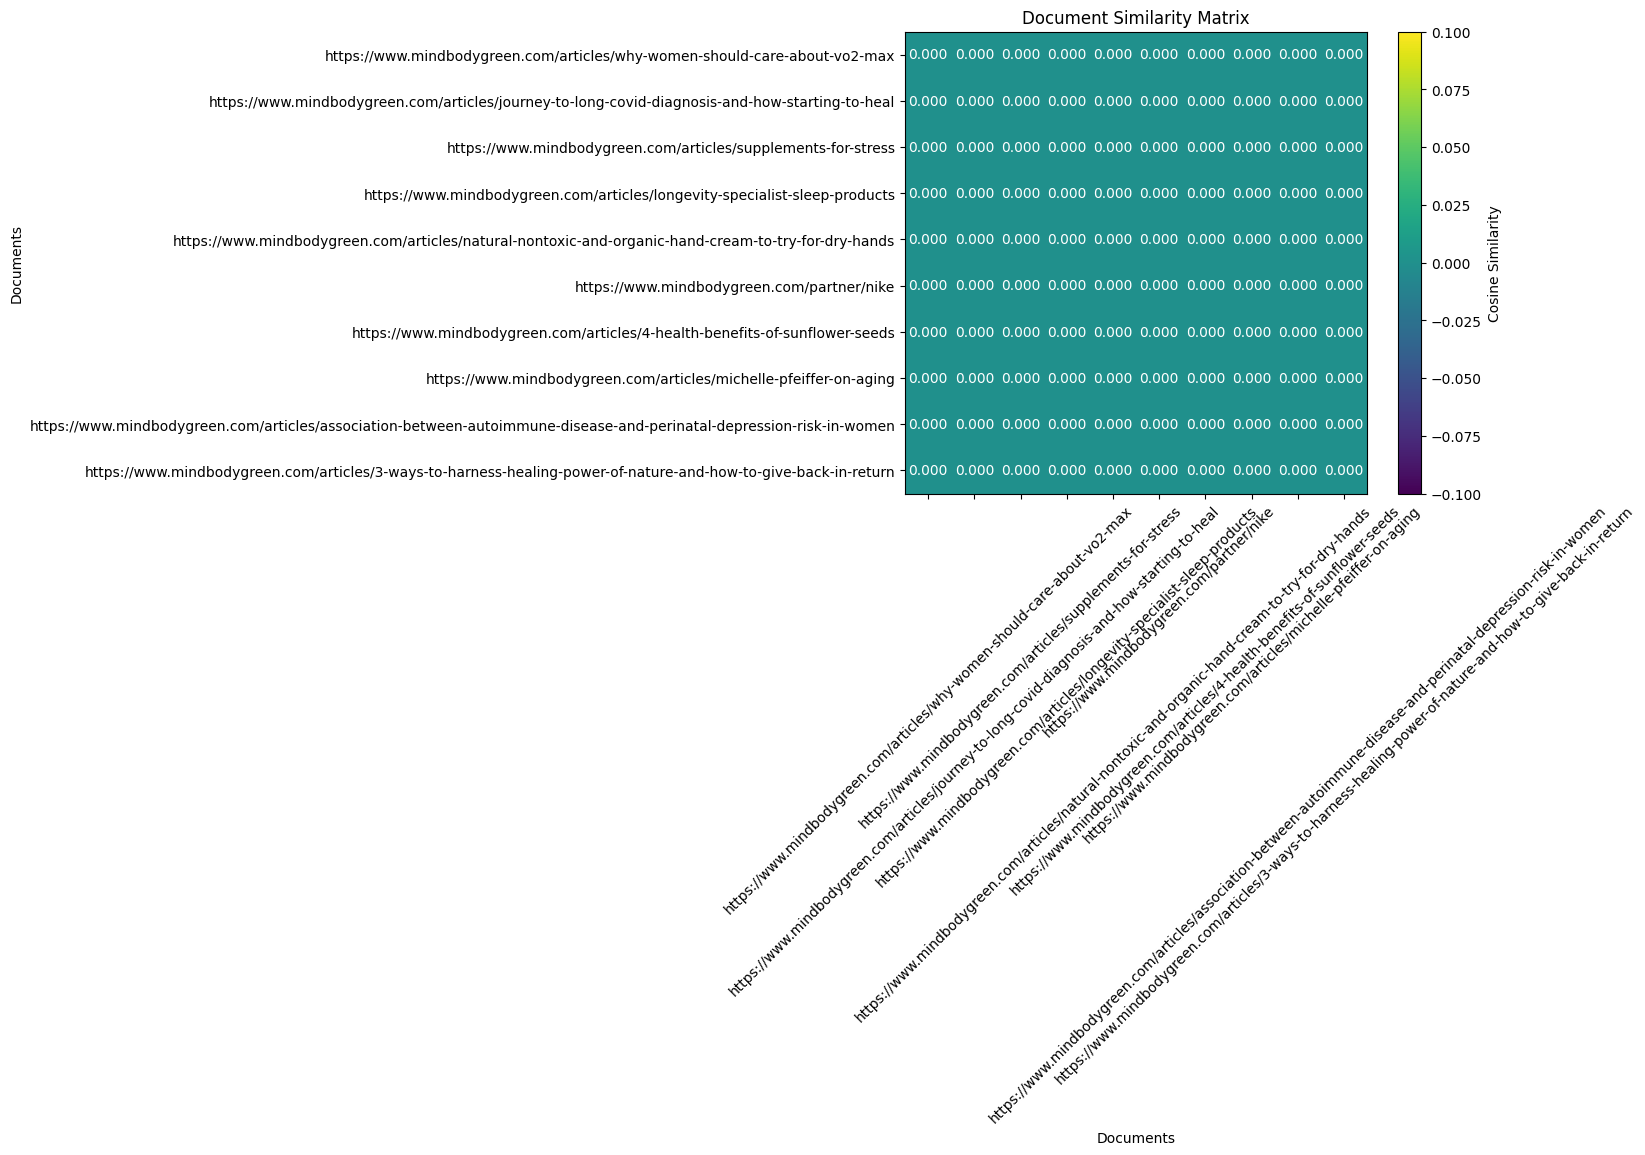

In [65]:
# Compute the cosine similarity matrix
similarity_matrix_tfidf = cosine_similarity(tf_idf)

# Convert to a DataFrame for better readability (optional)
similarity_df_tfidf = pd.DataFrame(similarity_matrix_tfidf, index=tf_idf.index, columns=tf_idf.index)

# Display the similarity DataFrame
display(similarity_df_tfidf)

def plot_similarity_matrix(similarity_df):
    # Plot the similarity matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_df, interpolation='nearest', cmap='viridis')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Document Similarity Matrix')
    plt.xticks(ticks=range(len(similarity_df.columns)), labels=similarity_df.columns, rotation=45)
    plt.yticks(ticks=range(len(similarity_df.index)), labels=similarity_df.index)
    plt.xlabel('Documents')
    plt.ylabel('Documents')

    # Optionally, annotate the cells with similarity values
    for i in range(len(similarity_df)):
        for j in range(len(similarity_df)):
            plt.text(j, i, f"{similarity_df.iloc[i, j]:.3f}", ha='center', va='center', color='white')

    plt.tight_layout()

plot_similarity_matrix(similarity_df_tfidf)

In [66]:

# Load corpus
df = pd.read_csv("normalized_wikipedia_lifestyle_corpus.csv")
documents = df["normalized_text"].astype(str).tolist()
documents = [d for d in documents if len(d.split()) > 100]  # remove documents with less than a 100 words (they are too short and only makes noise)

# Embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")  # It transforms every document in a vector which have meaning 

# Vectorizer
vectorizer_model = CountVectorizer(
    stop_words="english",
    min_df=3,
    ngram_range=(1, 2)
)

# KMeans clustering (NO hdbscan)  -> clustering of documents per topic (we can ask for x cluster)
cluster_model = KMeans(
    n_clusters=6,
    random_state=42,
    n_init="auto"
)

# BERTopic without hdbscan
topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    hdbscan_model=cluster_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(documents)

print(topic_model.get_topic_info())

FileNotFoundError: [Errno 2] No such file or directory: 'normalized_wikipedia_lifestyle_corpus.csv'